In [104]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
import pandas as pd
from cvlib.object_detection import draw_bbox
import datetime
from ipywidgets import *

In [136]:
class ImageFile(object):
    """A file that is a picture of droplets

    Attributes:
        path: The location of the file
        name: the file name
    """

    def __init__(self, path, name, file_type='png'):
        """Returns an ImageFile object"""
        self.path = path
        self.name = name
        self.file_type = file_type
        self.list_of_droplets = []
        self.creation_time = datetime.datetime.now().isoformat()

    def __repr__(self):
        return "ImageFile()"

    def __str__(self):
        return str(vars(self))

    def find_droplets(self, method='HOUGH'):
        """Find the position of droplets
        defaulting to the HoughCircles method from OpenCV2
        """
        param1 = 80
        param2 = 20
        minRadius = 5
        maxRadius = 50

        file_type = 'png'
        # The zero means that it will load in grayscale only
        file_to_open = '{0}/{1}.{2}'.format(self.path, self.name, file_type)
        print(file_to_open)
        in_img = cv2.imread(file_to_open)

        in_img_gray = cv2.cvtColor(
            in_img, cv2.COLOR_BGR2GRAY)  # grayscale concversion
        circles = cv2.HoughCircles(in_img_gray,
                                   cv2.HOUGH_GRADIENT,
                                   1,
                                   120,
                                   param1=param1,
                                   param2=param2,
                                   minRadius=minRadius,
                                   maxRadius=maxRadius)
        circles = np.uint16(np.around(circles))

        # Start the process of cutting out the droplets
        x_positions = circles[0, :, 0]
        y_positions = circles[0, :, 1]
        radii = circles[0, :, 2]

        cut_from = in_img.copy()

        for circle_index, value in enumerate(x_positions):
            x_pos = x_positions[circle_index]
            y_pos = y_positions[circle_index]
            radius = radii[circle_index]
            if circle_index > -1:
                # image_i=cut_from[x_pos:radius,y_pos:radius]
                image_i = cut_from[y_pos-radius*2:y_pos +
                                   radius*2, x_pos-radius*2:x_pos+radius*2]

                droplet = DropletImage(
                    original_image_path=self.path,
                    original_image_name=self.path,
                    path=self.path+'/Cuts',
                    image=image_i,
                    id_number=circle_index,
                    position=(x_pos, y_pos),
                    radius=radius, drop_type=None)
                self.list_of_droplets.append(droplet)


class DropletImage(object):
    """An image of a single droplet
    Attributes:
        original_image: the original image the droplet is from (path+name)
        path: the path to the  droplet image
        id_number: the id of the droplet
        position: the position of the droplet in the original image
        radius: the radius of the droplet
        type: the type of droplet
    """

    def __init__(self, original_image_path=None, original_image_name=None, path=None,
                 image=None, id_number=None, position=(None, None), radius=None, drop_type=None):
        """Returns an DropletImage object"""
        self.original_image_path = original_image_path
        self.original_image_name = original_image_name
        if path == None:
            self.path = self.original_image_path
        else:
            self.path = path
        self.image = image  # open cv object
        self.id_number = id_number
        self.position = position
        self.radius = radius
        self.drop_type = drop_type
        self.creation_time = datetime.datetime.now().isoformat()
        self.gen_descriptor()

    def __repr__(self):
        return "DropletImage()"

    def __str__(self):
        return str(vars(self))

#    def set_position(self, position=(None, None)):
#        """Set the position of the droplet in the original image"""
#        self.position = position

    def show_droplet(self):
        plt.imshow(self.image)  # openCV object

    def save_image(self):
        if self.desc_string == None:
            self.gen_descriptor()
        cv2.imwrite('{0}/{1}_x_{2}y_{3}r_{4}_cut{5}.png'.format(
                    self.path,
                    self.id,
                    self.position(0),
                    self.position(1),
                    self.radius,
                    self.id),
                    self.image)

    def gen_descriptor(self, desc_type=None):
        if desc_type == None:
            desc_string = '\t'.join(
                [self.creation_time,str(self.id_number), str(self.position), str(self.radius), str(self.drop_type)])
            header_string_1 = 'Droplets from {0}{1}\n'.format(
                self.original_image_path, self.original_image_name, self.creation_time)
            header_string_2 = '\t'.join(
                ['Date','ID', 'Position (x,y)', 'Radius', 'Type'])
            self.header_string = header_string_1+header_string_2
            self.desc_string = desc_string
            return desc_string
        else:
            return self.id

In [137]:
test_image_1 = ImageFile(
    '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images',
    '1.5mm_53.6ul_254.5kHz.png')

print(test_image_1)

test_droplet1 = DropletImage(test_image_1.path, test_image_1.name)

print(test_droplet1)

text = test_droplet1.gen_descriptor()
print(text)

{'path': '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images', 'name': '1.5mm_53.6ul_254.5kHz.png', 'file_type': 'png', 'list_of_droplets': [], 'creation_time': '2020-03-02T16:36:27.444628'}
{'original_image_path': '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images', 'original_image_name': '1.5mm_53.6ul_254.5kHz.png', 'path': '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images', 'image': None, 'id_number': None, 'position': (None, None), 'radius': None, 'drop_type': None, 'creation_time': '2020-03-02T16:36:27.444892', 'header_string': 'Droplets from /Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images1.5mm_53.6ul_254.5kHz.png\nDate\tID\tPosition (x,y)\tRadius\tType', 'desc_string': '2020-03-02T16:36:27.444892\tNone\t(None, None)\tNone\tNone'}
2020-03-02T16:36:27.444892	None	(None, None)	None	None


In [138]:
test_image_2 = ImageFile(
    '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images',
    '1.5mm_53.6ul_254.5kHz')

test_image_2.find_droplets()

/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/1.5mm_53.6ul_254.5kHz.png


Droplets from /Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images
Date	ID	Position (x,y)	Radius	Type
2020-03-02T16:36:27.888494	0	(658, 806)	33	None
Droplets from /Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images
Date	ID	Position (x,y)	Radius	Type
2020-03-02T16:36:27.888563	1	(362, 806)	33	None
Droplets from /Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images
Date	ID	Position (x,y)	Radius	Type
2020-03-02T16:36:27.888604	2	(1252, 800)	34	None
Droplets from /Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images
Date	ID	Position (x,y)	Radius	Type
2020-03-02T16:36:27.888642	3	(1848, 796)	32	None
Droplets from /Users/olofjonsson/Proje

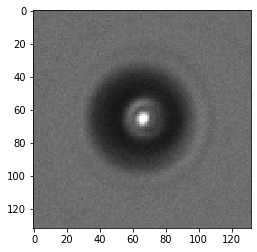

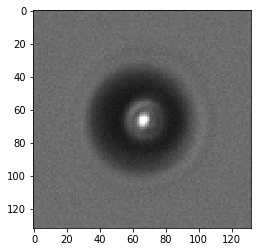

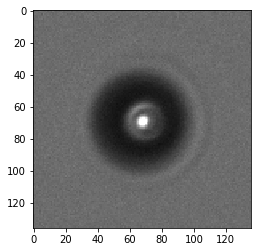

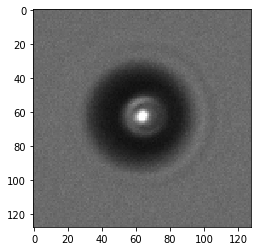

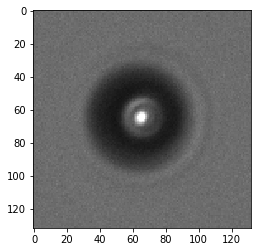

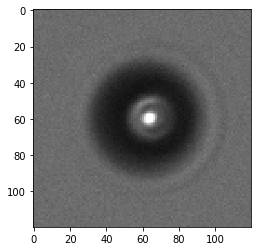

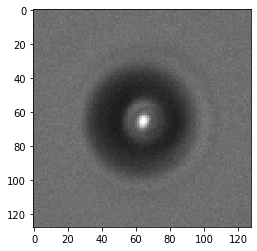

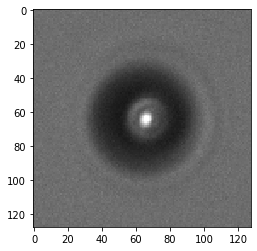

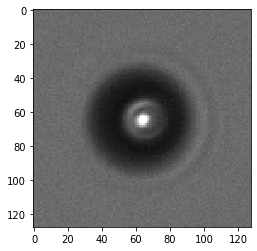

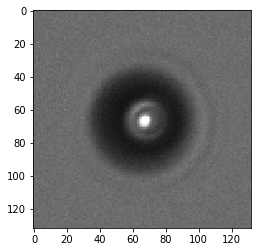

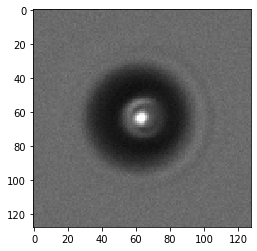

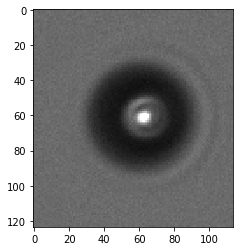

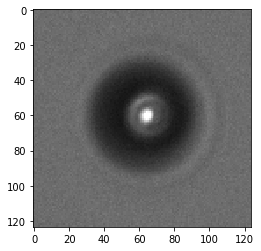

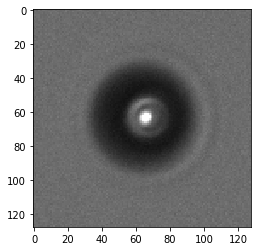

In [139]:

for i in test_image_2.list_of_droplets:
    plt.figure()
    plt.imshow(i.image)
    print(i.header_string)
    print(i.desc_string)

In [131]:
from datetime import date

today = date.today()

In [103]:
print(today)

2020-03-02
